# Import models and preparation of the environment

In [1]:
! pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.8 MB/s eta 0:00:00


In [2]:
import torch
from torchvision import transforms
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import rasterio
import seaborn as sns

In [3]:
!cp -r "/content/drive/MyDrive/AMAZON/" /content/dataset/

In [4]:
#Define root directory for the AMAZON dataset
dataset = "dataset"
root_dir = os.path.join("/content", dataset)
print("Root directory:", root_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Root directory: /content/dataset
cpu


In [5]:
def plot_metrics(metrics, model_name=None):
    """
    Plot training and validation metrics to evaluate model performance.

    Args:
        metrics (dict): Dictionary containing training and validation metrics
                       collected during training.

    Plots:
        - Training and Validation Loss over epochs
        - Validation IoU over epochs
        - Validation Precision, Recall, and Accuracy over epochs
    """
    import matplotlib.pyplot as plt

    # Calculate additional metrics from tp, fp, tn, fn
    tp = metrics['val']['tp_per_epoch']
    fp = metrics['val']['fp_per_epoch']
    tn = metrics['val']['tn_per_epoch']
    fn = metrics['val']['fn_per_epoch']

    # Precision = TP / (TP + FP)
    precision = [t / (t + f + 1e-7) for t, f in zip(tp, fp)]
    # Recall = TP / (TP + FN)
    recall = [t / (t + f + 1e-7) for t, f in zip(tp, fn)]
    # Accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracy = [(t + n) / (t + n + f + g + 1e-7) for t, n, f, g in zip(tp, tn, fp, fn)]

    epochs = list(range(1, len(metrics['train']['avg_loss_per_epoch']) + 1))

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 8))
    if model_name is None:
      title = "Model Training Metrics"
    else:
      title = f"Model Training Metrics for {model_name}"
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # Subplot 1: Loss
    axes[0, 0].plot(epochs, metrics['train']['avg_loss_per_epoch'], label='Train Loss', color='blue', linewidth=2, marker='o')
    axes[0, 0].plot(epochs, metrics['val']['avg_loss_per_epoch'], label='Val Loss', color='red', linewidth=2, marker='s')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Subplot 2: IoU
    axes[0, 1].plot(epochs, metrics['val']['iou_per_epoch'], label='IoU', color='green', linewidth=2, marker='^')
    axes[0, 1].set_title('Validation IoU')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('IoU')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    #Subplot 3: Confusion Matrix
    cm = np.array([
      [metrics["val"]["tn_per_epoch"][-1], metrics["val"]["fp_per_epoch"][-1]],
      [metrics["val"]["fn_per_epoch"][-1], metrics["val"]["tp_per_epoch"][-1]]
    ]).astype(int)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', ax=axes[1, 0],
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'])
    axes[1, 0].set_title('Confusion Matrix (Last Epoch)')

    # Subplot 4: Precision
    axes[1, 1].plot(epochs, precision, label='Precision', color='orange', linewidth=2, marker='x')
    axes[1, 1].set_title('Validation Precision')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Precision')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Model Definition
There is one block of code for each model, so only run the model you want to train.

1. PAN (Pyramid Attention Network)

In [ ]:
# Define model
model_name = "PAN" # This will appear in the title of the training metric report

model_amazon = smp.PAN(
    encoder_name = 'resnet34',
    encoder_weights = 'imagenet',
    in_channels = 4,
    classes = 1,
    activation='sigmoid'
    ).to(device)

#loss & optimizer
criterion = smp.losses.DiceLoss(mode='binary') #loss
optimizer = torch.optim.Adam(model_amazon.parameters(), lr=0.0001) #optimizer

2. U-Net

In [6]:
# Define model
model_name = "U-Net"

model_amazon = smp.Unet(
    encoder_name = 'resnet34',
    encoder_weights = 'imagenet',
    in_channels = 4,
    classes = 1,
    activation='sigmoid'
    ).to(device)

#loss & optimizer
criterion = smp.losses.DiceLoss(mode='binary') #loss
optimizer = torch.optim.Adam(model_amazon.parameters(), lr=0.0001) #optimizer

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

3. FPN (Feature Pyramid Network)

In [ ]:
model_name = "FPN"

model_amazon = smp.FPN(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=4,
    classes=1,
    activation='sigmoid'
    ).to(device)

#loss & optimizer
criterion = smp.losses.DiceLoss(mode='binary') #loss
optimizer = torch.optim.Adam(model_amazon.parameters(), lr=0.0001) #optimizer

4. DeepLabV3+

In [ ]:
model_name = "DeepLabV3+"
model_amazon = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=4,
    classes=1,
    activation='sigmoid'
).to(device)

#loss & optimizer
criterion = smp.losses.DiceLoss(mode='binary') #loss
optimizer = torch.optim.Adam(model_amazon.parameters(), lr=0.0001) #optimizer

5. U-Net++

In [ ]:
model_name = "U-Net++"
model_amazon = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=4,
    classes=1,
    activation='sigmoid'
).to(device)

#loss and optimizer
criterion = smp.losses.DiceLoss(mode='binary') #loss
optimizer = torch.optim.Adam(model_amazon.parameters(), lr=0.0001) #optimizer

# Training and Metrics

In [7]:
# Evaluation Mode
model_amazon.eval()

# Prediction Function
def predict(md,image, threshold=0.5):
    model = md
    with torch.no_grad():
        output = model(image)  # [1, 1, H, W]
        pred = (output> threshold).float()

    return pred.squeeze().cpu().numpy()

In [8]:
def train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device, num_classes=1, plot_results=True, patience=5, monitor_metric='val_loss'):
    """
    Train the model with early stopping.

    Args:
        model: The model to train.
        criterion: Loss function.
        optimizer: Optimizer.
        num_epochs: Maximum number of epochs.
        train_loader: Training data loader.
        val_loader: Validation data loader.
        device: Device to train on.
        num_classes: Number of classes (for future use).
        plot_results: Whether to plot results (not implemented yet).
        patience: Number of epochs to wait for improvement before stopping.
        monitor_metric: Metric to monitor for early stopping ('val_loss', 'iou', 'dice').
    """

    metrics = {
        "train": {
            "loss_per_batch": [],
            "avg_loss_per_epoch": []
        },
        "val": {
            "loss_per_batch": [],
            "avg_loss_per_epoch": [],
            "iou_per_epoch": [],
            "tp_per_epoch": [],
            "fp_per_epoch": [],
            "tn_per_epoch": [],
            "fn_per_epoch": []
        }
    }

    # For early stopping
    best_metric = float('inf') if monitor_metric == 'val_loss' else 0.0
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")

        # ===== TRAINING =====
        model.train()
        epoch_train_loss = 0.0

        for batch_idx, (images, masks) in enumerate(train_loader, 1):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            metrics["train"]["loss_per_batch"].append(loss.item())
            print(f"  Train batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}")

        avg_train_loss = epoch_train_loss / len(train_loader)
        metrics["train"]["avg_loss_per_epoch"].append(avg_train_loss)

        # Validation loop
        model.eval()
        epoch_val_loss = 0.0
        tpsum, tnsum, fpsum, fnsum = 0.0, 0.0, 0.0, 0.0

        with torch.no_grad():
            for batch_idx, (images, masks) in enumerate(val_loader, 1):
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                # Get metrics
                epoch_val_loss += loss.item()
                tp, fp, fn, tn = smp.metrics.get_stats((outputs > 0.5).long().squeeze(1), masks.long().squeeze(1), mode='binary')

                # safe metrics
                tpsum += tp.sum().item()
                tnsum += tn.sum().item()
                fpsum += fp.sum().item()
                fnsum += fn.sum().item()

                print(
                    f"  Val batch {batch_idx}/{len(val_loader)} | "
                    f"Loss: {loss.item():.4f}"
                )

        avg_val_loss = epoch_val_loss / len(val_loader)
        dice_epoch = (2 * tpsum) / (2 * tpsum + fpsum + fnsum + 1e-7)
        iou = tpsum / (tpsum + fpsum + fnsum + 1e-7)

        metrics["val"]["avg_loss_per_epoch"].append(avg_val_loss)
        metrics["val"]["iou_per_epoch"].append(iou)
        metrics["val"]["tp_per_epoch"].append(tpsum)
        metrics["val"]["tn_per_epoch"].append(tnsum)
        metrics["val"]["fp_per_epoch"].append(fpsum)
        metrics["val"]["fn_per_epoch"].append(fnsum)

        print(
            f"\nEpoch Summary:"
            f"\n  Train Loss: {avg_train_loss:.4f}"
            f"\n  Val Loss:   {avg_val_loss:.4f}"
            f"\n  Val IoU:    {iou:.4f}"
        )

        # Early Stopping Check
        current_metric = {
            'val_loss': avg_val_loss,
            'iou': iou
        }[monitor_metric]

        if monitor_metric == 'val_loss':
            improved = current_metric < best_metric
        else:
            improved = current_metric > best_metric

        if improved:
            print(f"  -> Improvement in {monitor_metric}: {current_metric - best_metric:.4f}")
            best_metric = current_metric
            patience_counter = 0
            best_model_state = model.state_dict().copy()  # Save best model yet
        else:
            patience_counter += 1
            print(f"  -> No improvement in {monitor_metric} for {patience_counter} epochs.")

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs (no improvement in {monitor_metric} for {patience} epochs).")
            break


    # Best model !!
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Loaded best model state.")

    torch.save(model.state_dict(), "forest_model_final.pth")
    print("\nTraining finished.")

    if(plot_results):
        plot_metrics(metrics, model_name=model_name)

    return metrics, model

In [9]:
#Dataset definition

class AmazonDataset(Dataset):
    def __init__(self, root_dir=root_dir, transform=None, mask_transform=None):
        self.root_dir = root_dir
        self.images = sorted(os.listdir(os.path.join(root_dir, "image")))
        self.masks = sorted(os.listdir(os.path.join(root_dir, "label")))
        self.transform = transform
        self.mask_transform = mask_transform

        print(f" #images == #masks = {len(self.images) == len(self.masks)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_dir = os.path.join(self.root_dir, "image")
        mask_dir = os.path.join(self.root_dir, "label")

        with rasterio.open(os.path.join(image_dir, self.images[index])) as src:
            image = src.read()
            image = (image / 10000 * 255).astype(np.uint8)
        with rasterio.open(os.path.join(mask_dir, self.masks[index])) as src:
            mask = src.read()
            mask = mask.astype(np.float32).squeeze(0)  # (1, H, W) -> (H, W), Float32

        if self.transform:
            image = np.moveaxis(image, 0, -1)  # (4, H, W) -> (H, W, 4)
            image = self.transform(Image.fromarray(image))

        if self.mask_transform:
            mask = self.mask_transform(Image.fromarray(mask.astype(np.uint8)))
            mask = (mask > 0).long()

        return image, mask

In [10]:
#Definition of transforms and data loaders for training

mean = torch.tensor([0.485, 0.456, 0.406, 0.5])
std  = torch.tensor([0.229, 0.224, 0.225, 0.5])
preprocess = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Binary for mask (It's always 0 or 1)
mask_preprocess = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

train_data_amazon = AmazonDataset(os.path.join(root_dir, "Training"), transform=preprocess, mask_transform=mask_preprocess)
val_data_amazon = AmazonDataset(os.path.join(root_dir, "Validation"), transform=preprocess, mask_transform=mask_preprocess)
train_loader_amazon = DataLoader(train_data_amazon, batch_size=8, shuffle=True, pin_memory=True)
val_loader_amazon = DataLoader(val_data_amazon, batch_size=8, shuffle=False, pin_memory=True)

 #images == #masks = True
 #images == #masks = True



Epoch [1/30]
  Train batch 1/63 | Loss: 0.4136
  Train batch 2/63 | Loss: 0.4831
  Train batch 3/63 | Loss: 0.4671
  Train batch 4/63 | Loss: 0.3852
  Train batch 5/63 | Loss: 0.4423
  Train batch 6/63 | Loss: 0.4985
  Train batch 7/63 | Loss: 0.3686
  Train batch 8/63 | Loss: 0.4330
  Train batch 9/63 | Loss: 0.3920
  Train batch 10/63 | Loss: 0.4096
  Train batch 11/63 | Loss: 0.3826
  Train batch 12/63 | Loss: 0.3693
  Train batch 13/63 | Loss: 0.4438
  Train batch 14/63 | Loss: 0.3704
  Train batch 15/63 | Loss: 0.5101
  Train batch 16/63 | Loss: 0.5295
  Train batch 17/63 | Loss: 0.3866
  Train batch 18/63 | Loss: 0.3248
  Train batch 19/63 | Loss: 0.3507
  Train batch 20/63 | Loss: 0.4943
  Train batch 21/63 | Loss: 0.4319
  Train batch 22/63 | Loss: 0.3557
  Train batch 23/63 | Loss: 0.3994
  Train batch 24/63 | Loss: 0.3373
  Train batch 25/63 | Loss: 0.3922
  Train batch 26/63 | Loss: 0.3745
  Train batch 27/63 | Loss: 0.3875
  Train batch 28/63 | Loss: 0.4149
  Train batch 2

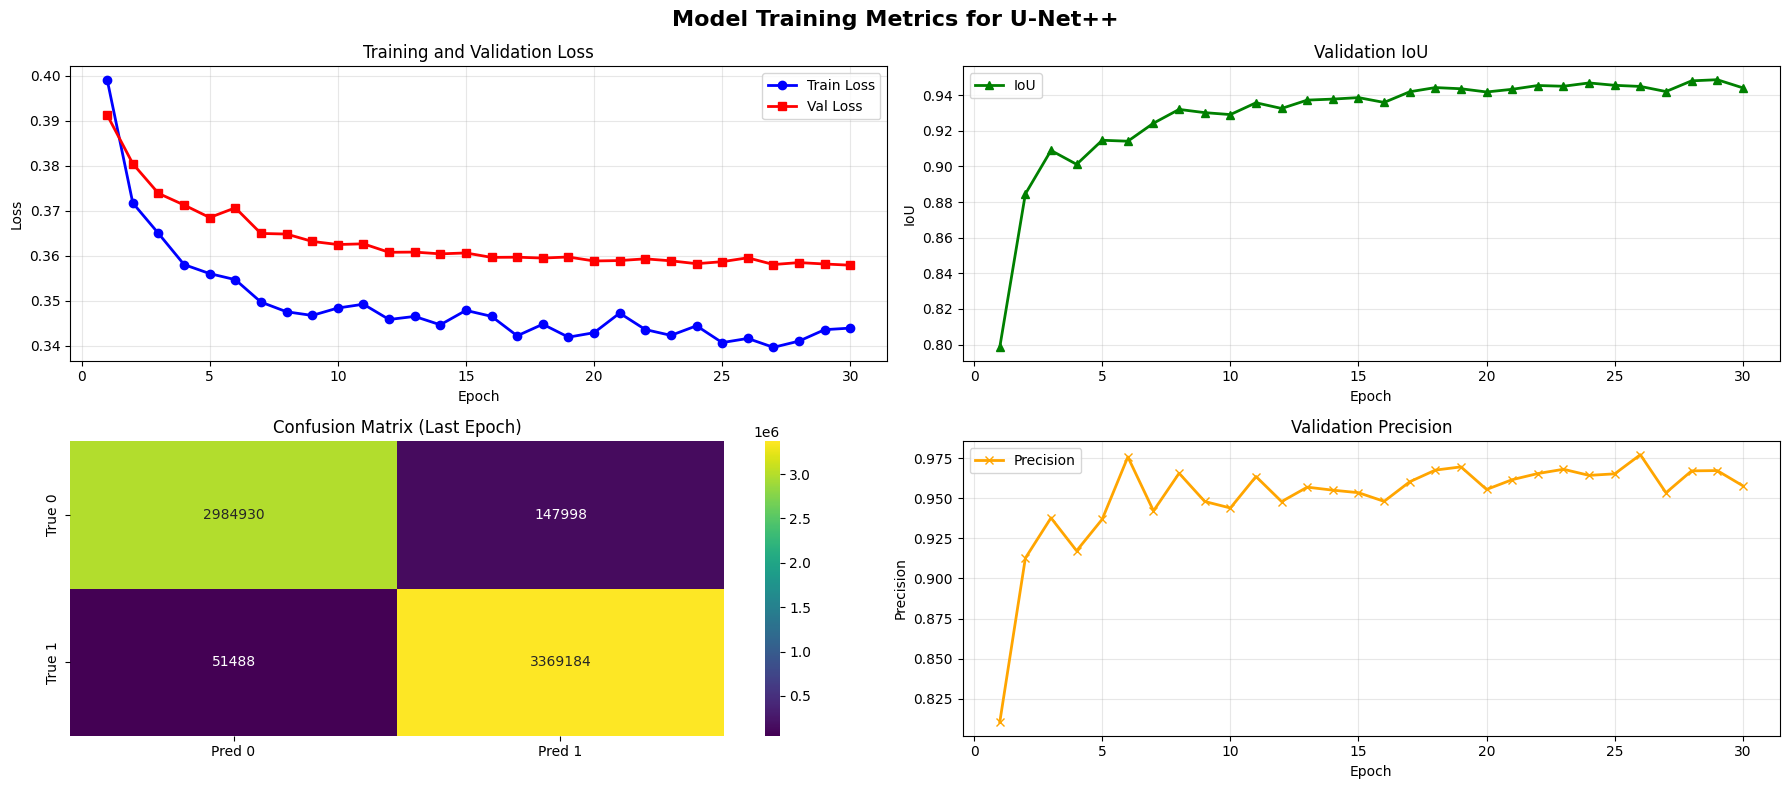

In [ ]:
#Train!
val_metrics, trained_model = train_model(model_amazon, criterion, optimizer, 30, train_loader_amazon, val_loader_amazon, device, patience=7, monitor_metric='iou')

Visualisation of any data with the given model

In [11]:
#Load a model if needed
state_dict = torch.load('unet.pth', map_location=device)
model_amazon.load_state_dict(state_dict)
model_amazon.to(device)
model_amazon.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

 #images == #masks = True
13


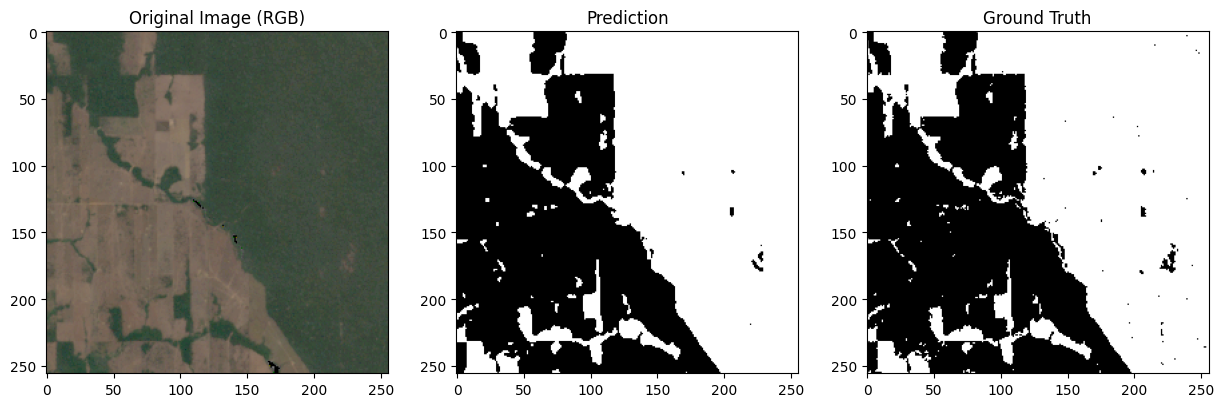

In [12]:
test_data_amazon = AmazonDataset(os.path.join(root_dir, "Test"), transform=preprocess, mask_transform=mask_preprocess)

i=13
#i = np.random.randint(0, len(test_data_amazon)) # for a random datapoint
print(i)

preds = predict(model_amazon, test_data_amazon[i][0].unsqueeze(0).to(device))

plt.figure(figsize=(15,5))
img, mask = test_data_amazon[i]
plt.subplot(1,3,1)
img_to_plot = img.permute(1,2,0).cpu().numpy()
# Denormalization
img_to_plot = img_to_plot * np.array([0.229, 0.224, 0.225, 0.5]) + np.array([0.485, 0.456, 0.406, 0.5])
img_to_plot = np.clip(img_to_plot, 0, 1)
img_to_plot = np.power(img_to_plot, 0.4)
plt.imshow(img_to_plot[:, :, :3])
plt.title("Original Image (RGB)")

plt.subplot(1,3,2)
plt.imshow(preds, cmap='gray')
plt.title("Prediction")

plt.subplot(1,3,3)
plt.imshow(mask.squeeze(0).cpu().numpy(), cmap='gray')
plt.title("Ground Truth")

plt.show()